# Sensitivity Analysis - Sensitivity Scoring

This notebook shows how sensitivity scores were calculated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400

from sensitivity.statesensitivity import StateSensitivity

Once we obtained the steady state concentrations after multiplying each one of the regulatory functions separately by a scale factor, we can see how components react to different changes in rate constants. For example, for the W state we notice that $k_{23}$ does not seem to affect too many components.

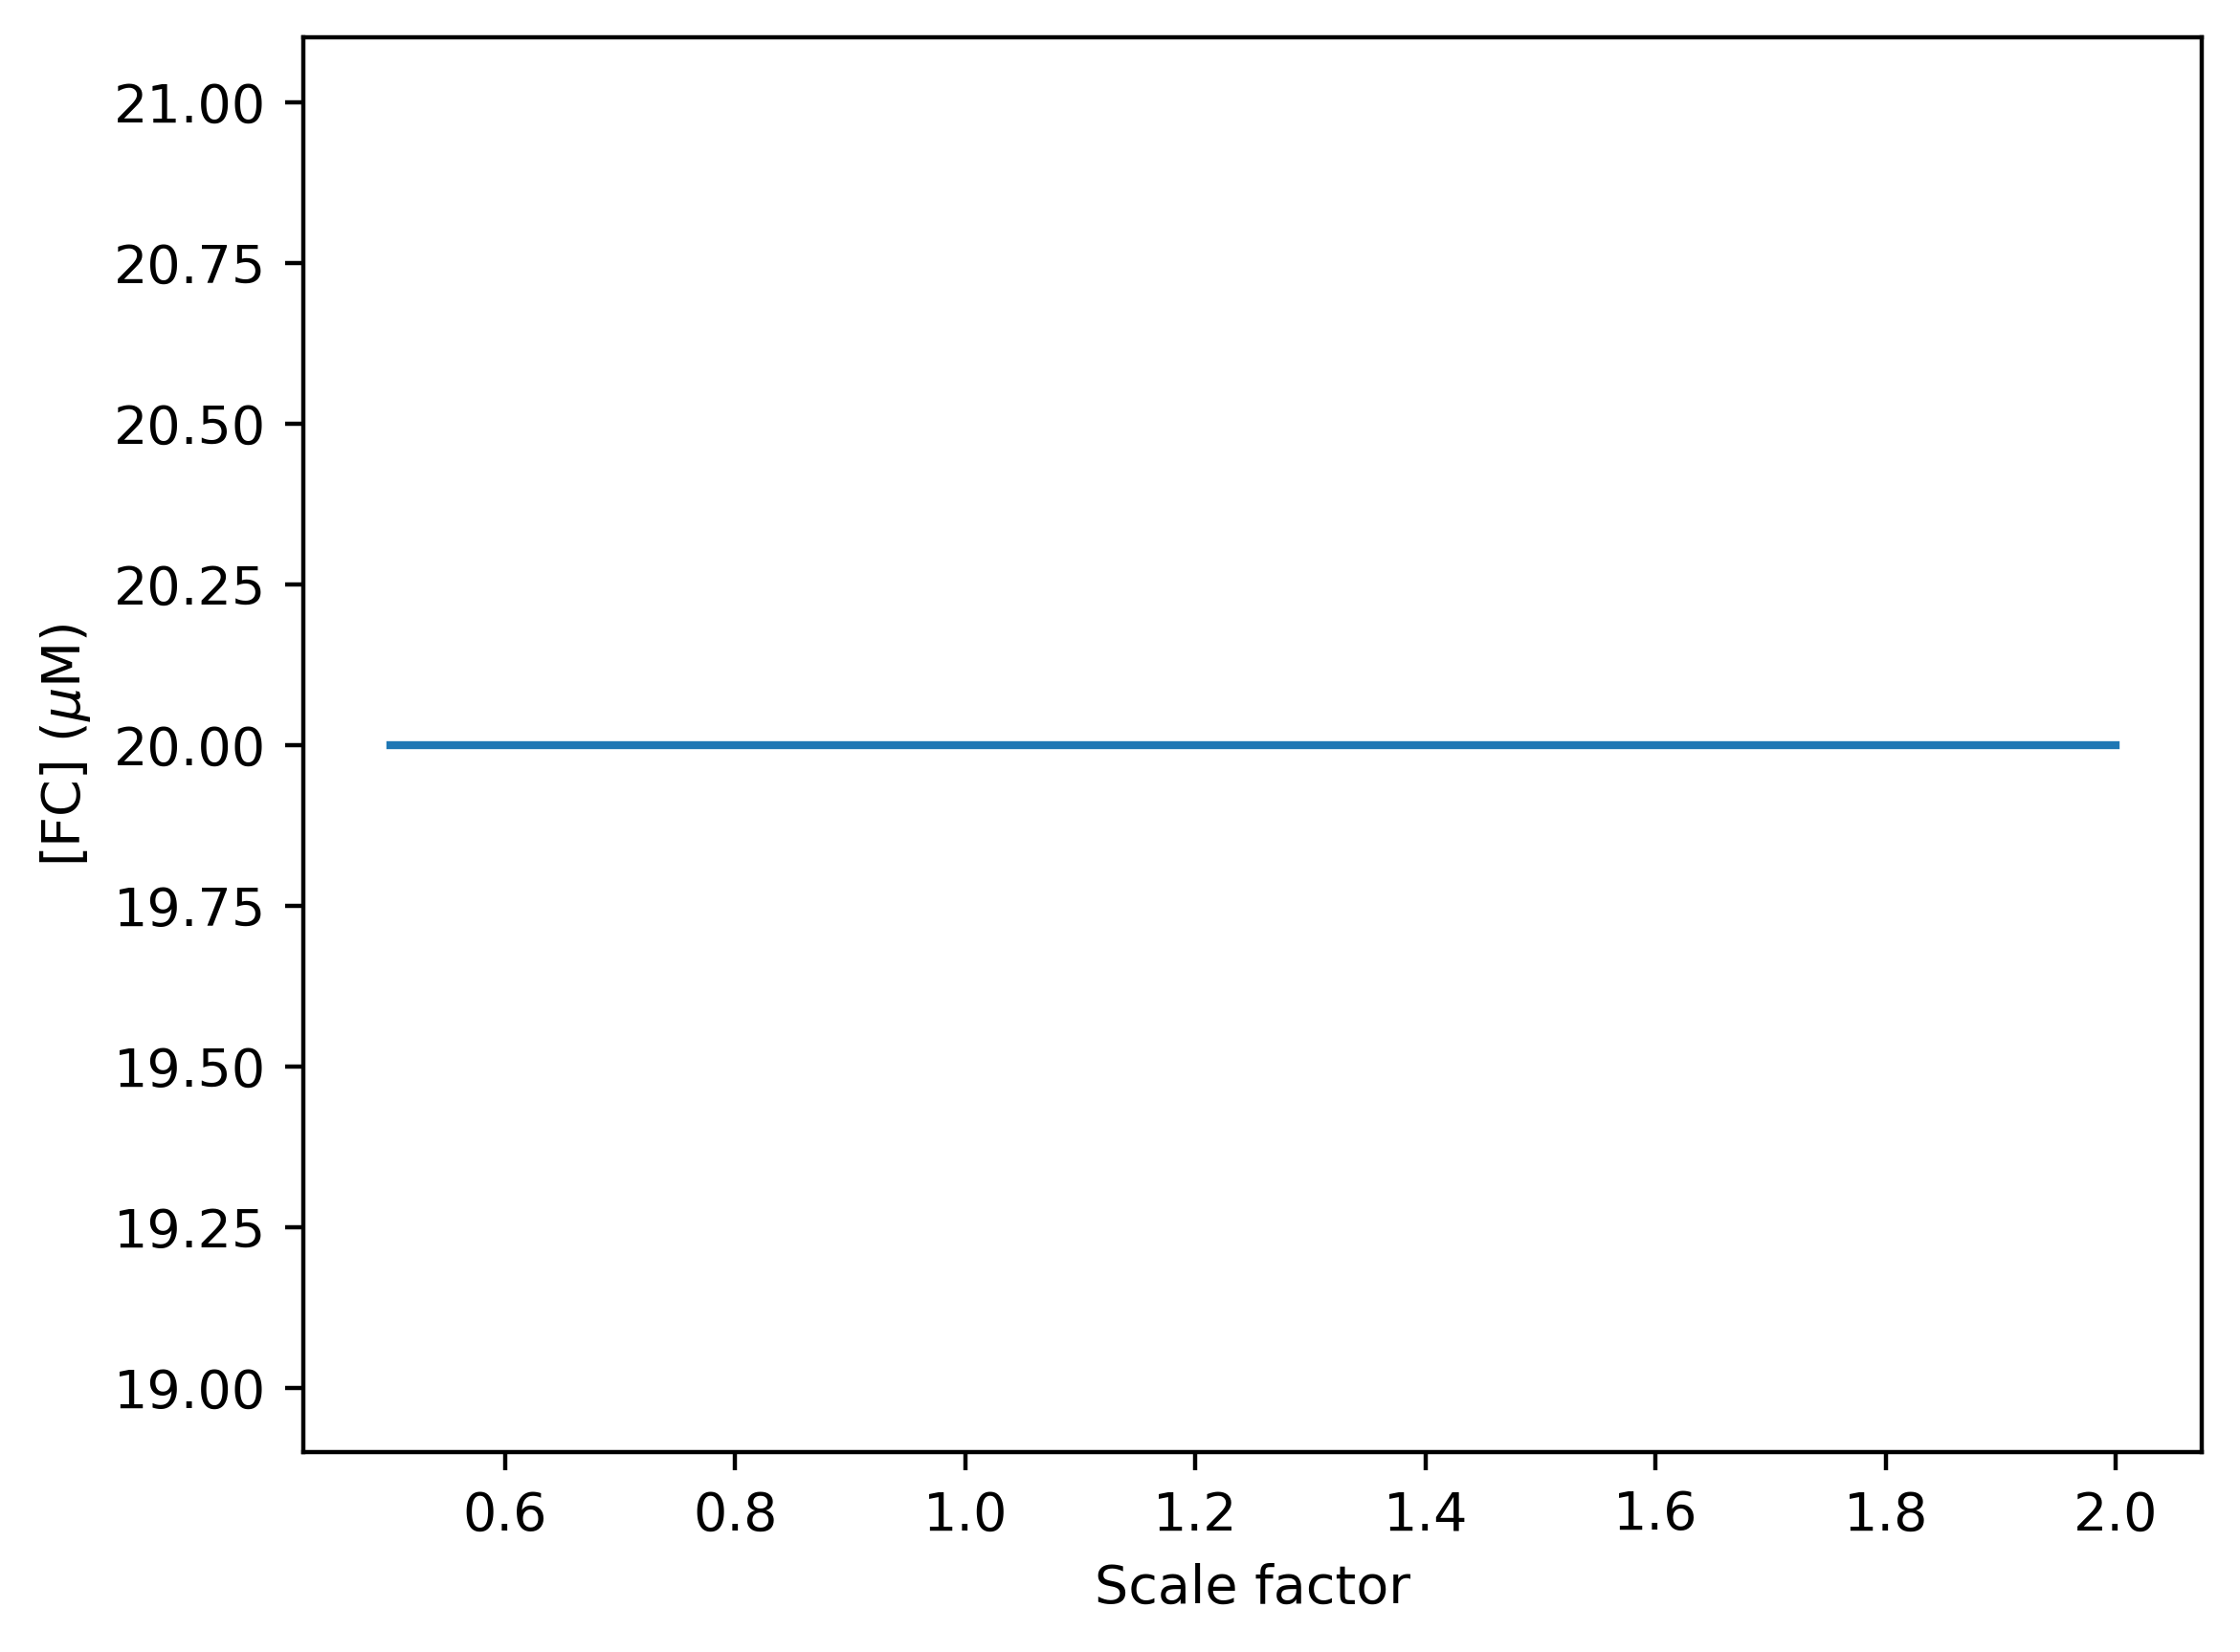

In [2]:
wsens = StateSensitivity("data/w_sensitivity.csv",'W')
# plot FC change with respective to k23
fc_k23changes = wsens.rateConstants["k23"].dataframe["FC"].values
factors = wsens.rateConstants["k23"].dataframe["factor"].values
plt.plot(factors, fc_k23changes)
plt.xlabel("Scale factor")
plt.ylabel("[FC] ($\mu$M)")
plt.show()



In contrast, F2 is very sensitive with respect to $k_{23}$:

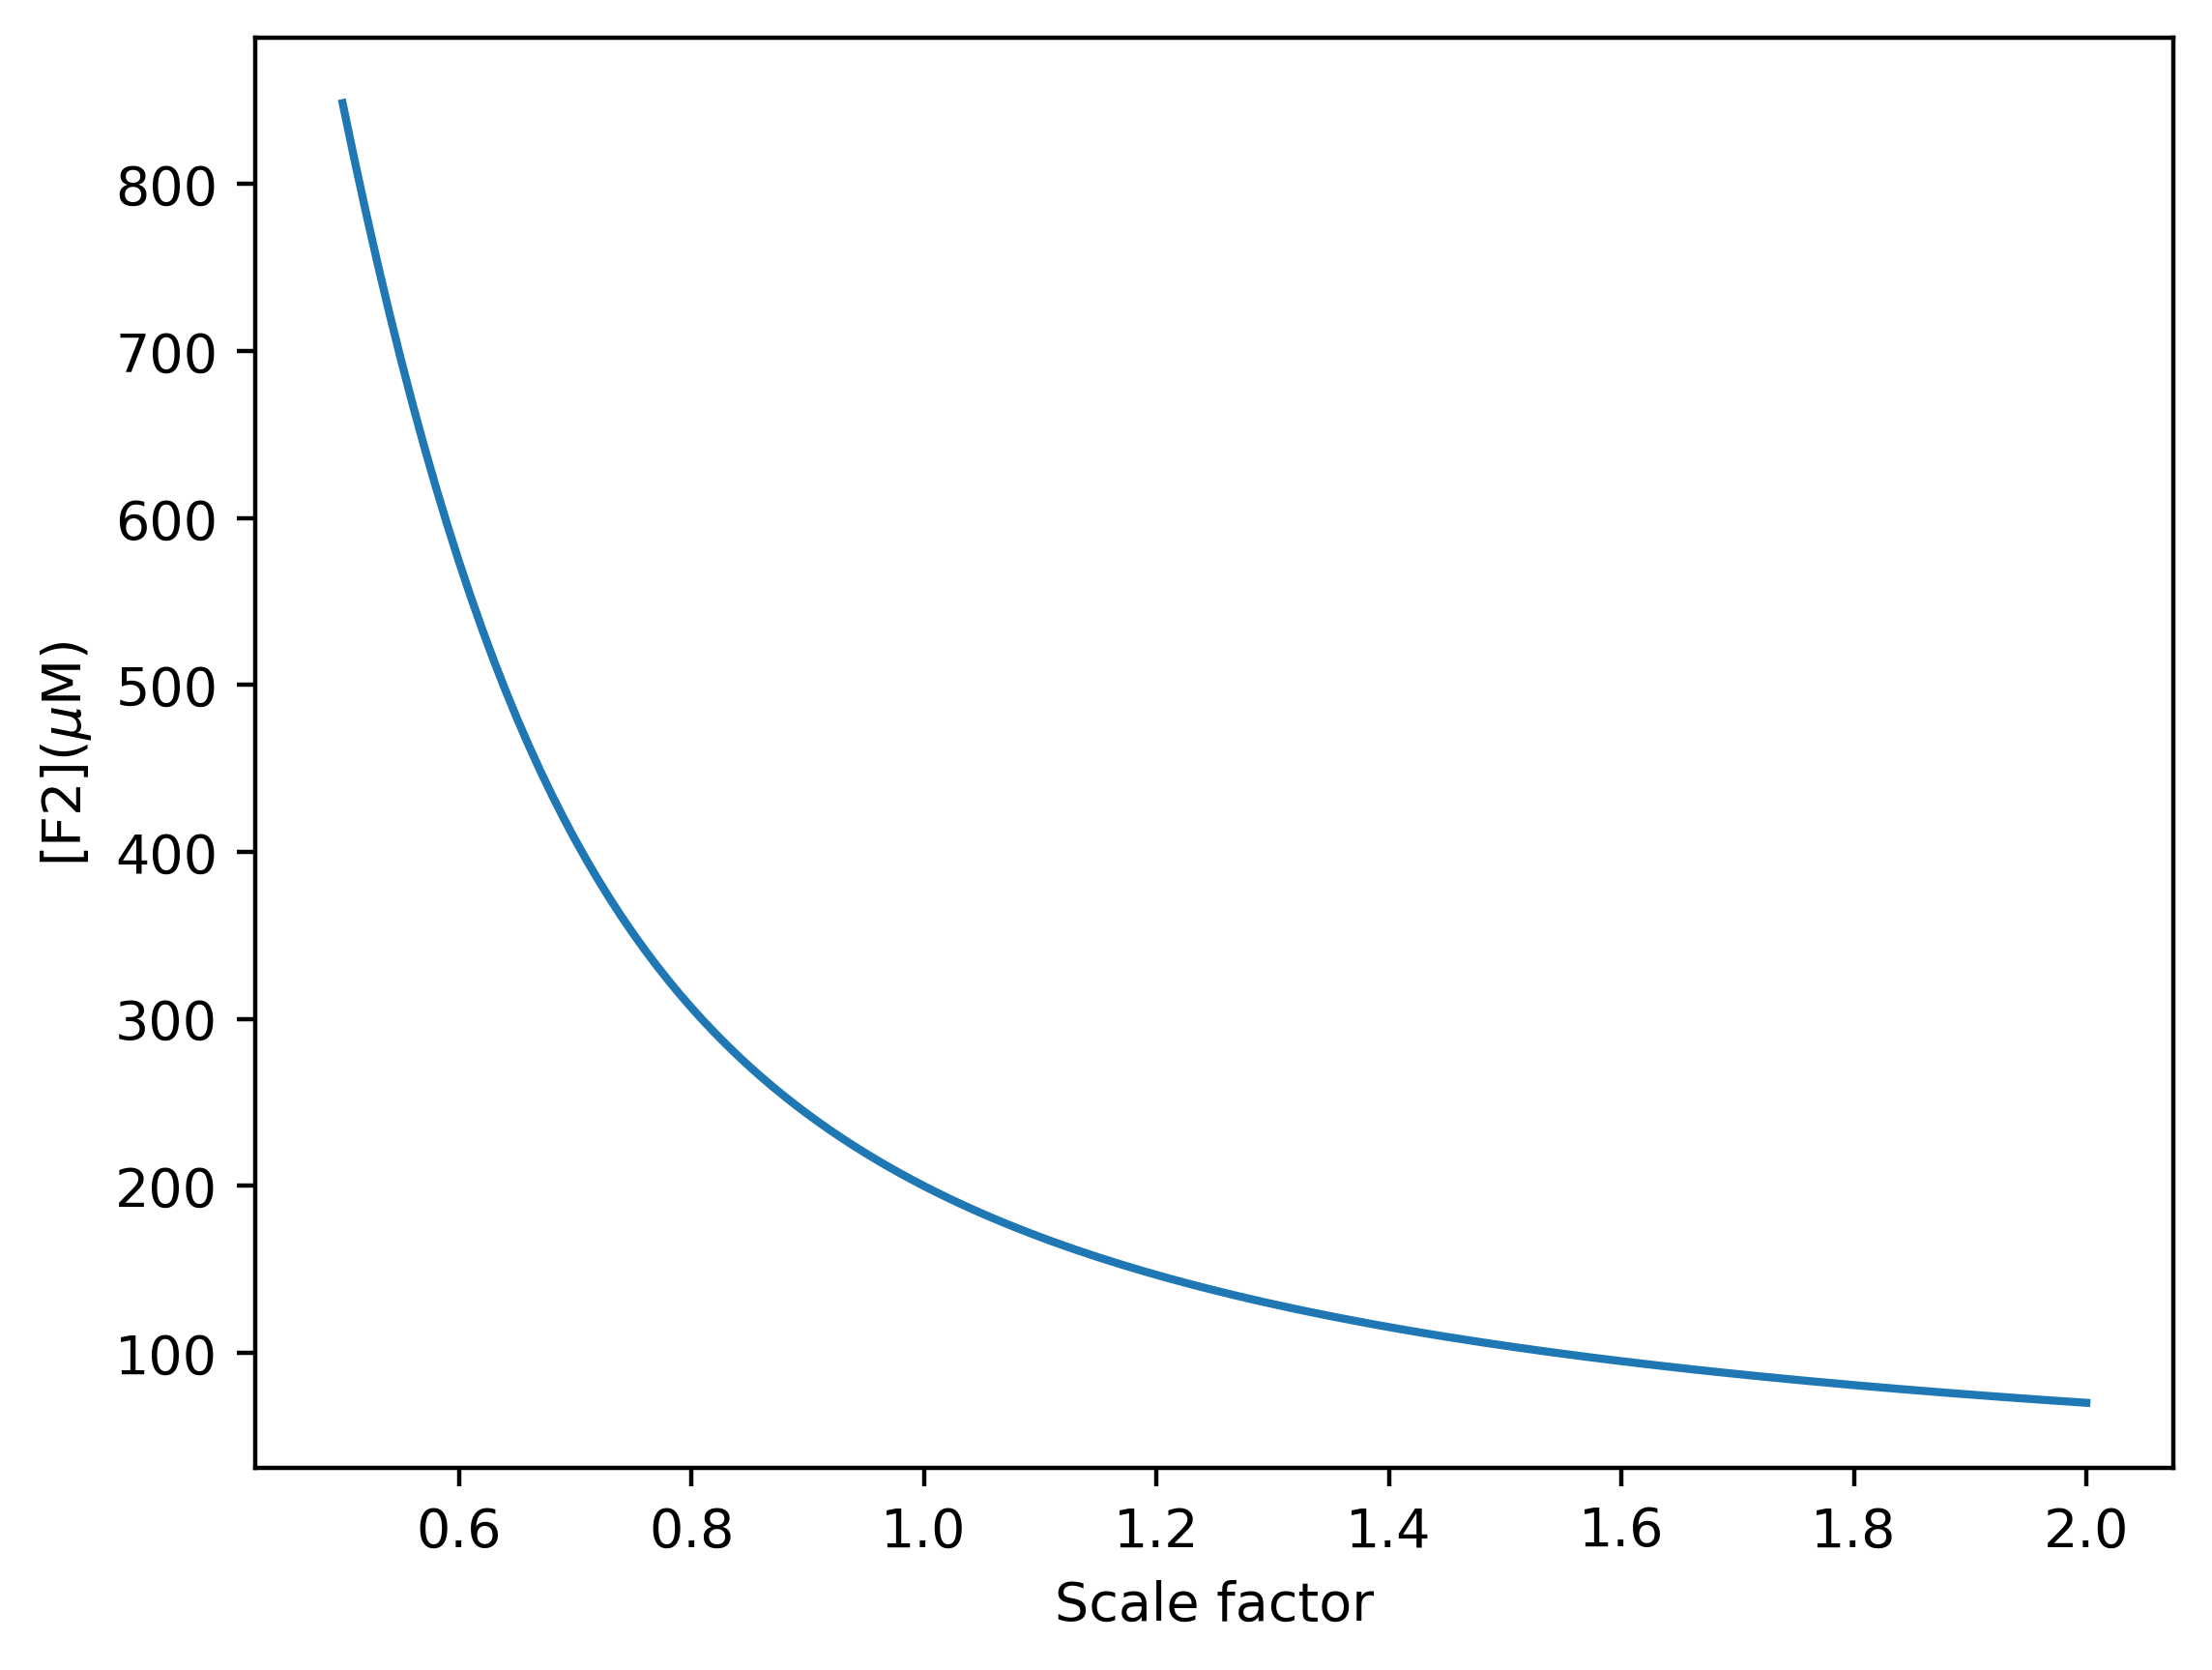

In [3]:
f2_k23changes = wsens.rateConstants["k23"].dataframe["F2"].values
factors = wsens.rateConstants["k23"].dataframe["factor"].values
plt.plot(factors, f2_k23changes)
plt.xlabel("Scale factor")
plt.ylabel("[F2]($\mu$M)")
plt.show()

Instead of using raw component concentrations, we can use percent changes in component concentrations from the baseline (where our scale factor is 1).

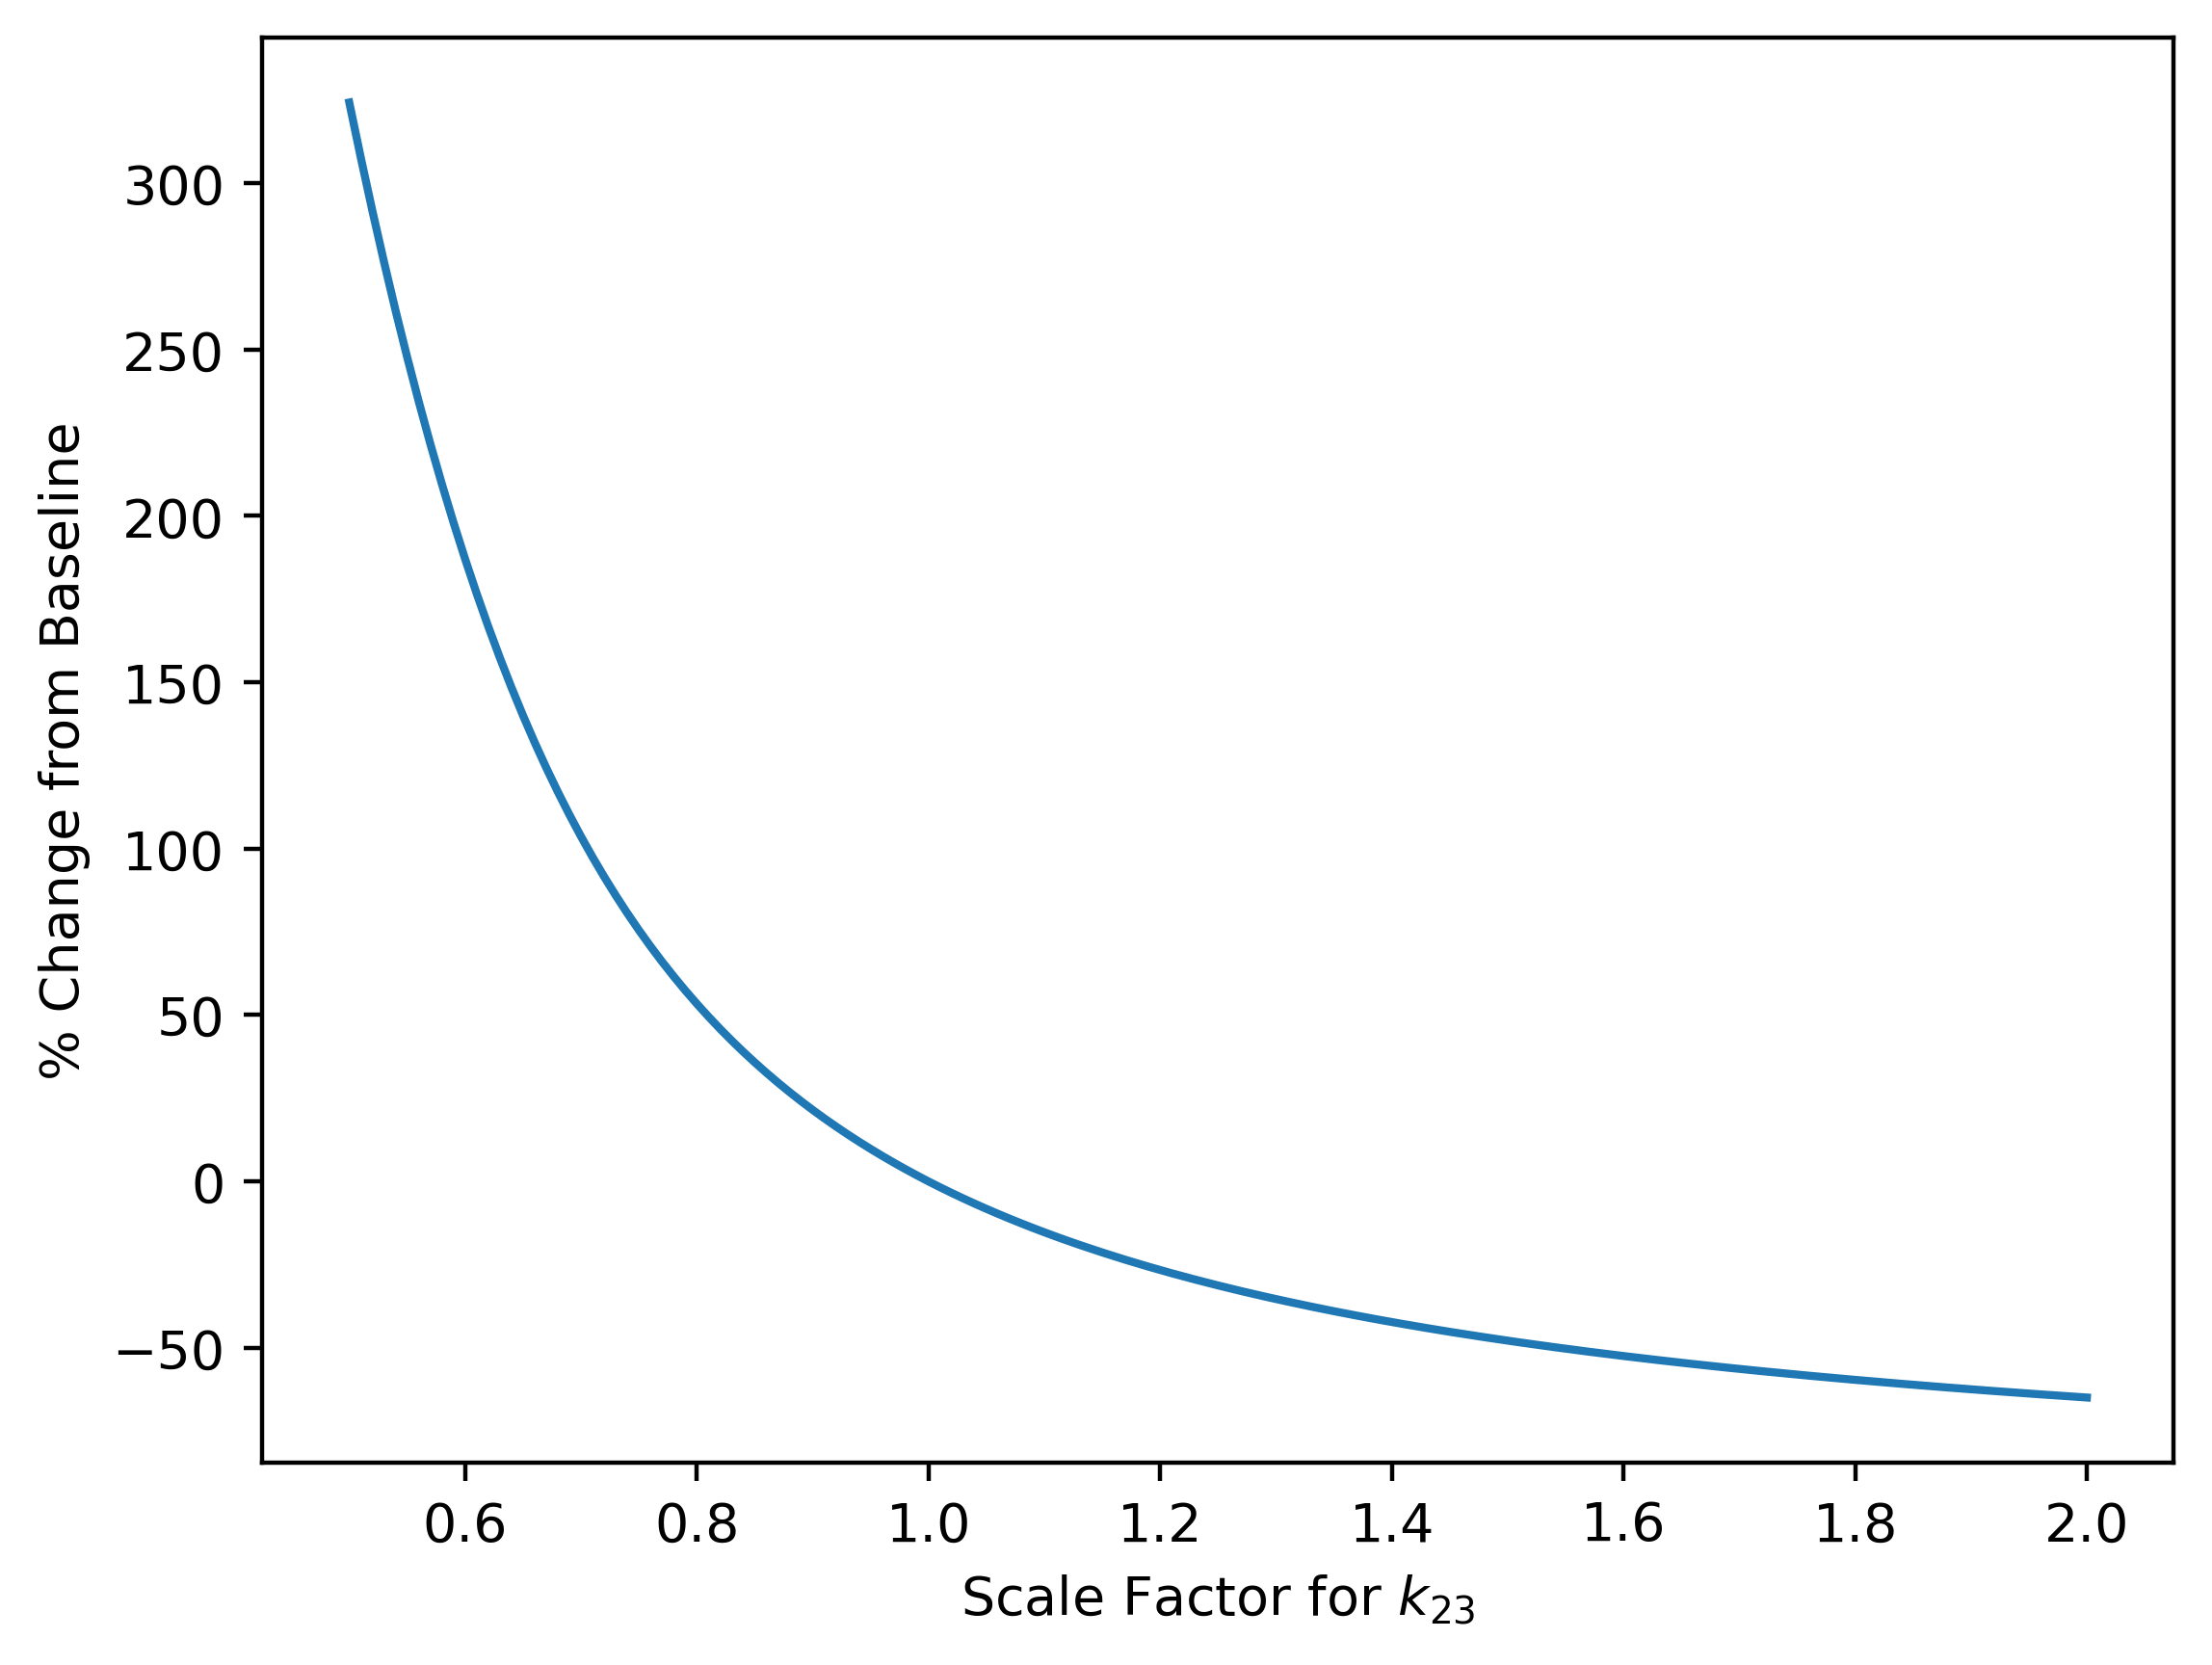

In [4]:
f2_pd = wsens.rateConstants["k23"].getPercentDifference("F2")
plt.plot(factors, f2_pd)
plt.xlabel("""Scale Factor for $k_{23}$""")
plt.ylabel("% Change from Baseline")
plt.show()

We defined the sensitivity between a component and a rate constant for one state as the approximated slope for the percent change function $G$ with increments of $j = 0.01$ where $h = 1$. The slope is then divided by the component concentration baseline $C_{i}$. 

$$\text{Sensitivity for Rate Constant and Component}= s_{i} = \frac{\frac{G(h - 2j) - 8G(h-j) + 8G(h+j) + G(h+2j)}{12j}}{C_i}$$

Doing that for $k_{23}$ and F2, we get:

In [5]:
k23frame = wsens.rateConstants["k23"].dataframe

# look between 1 - 2(0.01) and 1 + 2(0.01) -> [0.98, 1.02]
targetFrame = k23frame[k23frame["factor"].between(0.98,1.02)][["alteredRateConstant", "factor", "F2"]]
targetFrame

,alteredRateConstant,factor,F2
48,k23,0.98,207.410
49,k23,0.99,203.642
50,k23,1.00,200.001
51,k23,1.01,196.482
52,k23,1.02,193.078


In [6]:
# convert to percent difference
baseF2 = targetFrame.iloc[2].to_dict()["F2"]
G = (targetFrame["F2"].values - baseF2)/baseF2 * 100
slope = (G[0] - 8*G[1] + 8*G[3] + G[4])/(12 * 0.01)
print("Sensitivity Score for F2 and k23 for W state is", slope/baseF2)

Sensitivity Score for F2 and k23 for W state is -1.1831965013387398


We can verify this via the helper function that is implemented:

In [7]:
wsens.rateConstants["k23"].getComponentSensitivity("F2")

-1.1831965013387398

In [8]:
dsens = StateSensitivity("data/d_sensitivity.csv",'D')
ysens = StateSensitivity("data/y_sensitivity.csv",'Y')
finalSensitivities = dict()
finalSensitivities["W"] = wsens.getRateConstantSensitivities()
finalSensitivities["Y"] = ysens.getRateConstantSensitivities()
finalSensitivities["D"] = dsens.getRateConstantSensitivities()
pd.DataFrame(finalSensitivities)

,W,Y,D
kO2,59.092931,40.278994,46.774678
kmit,25.609876,1.705068,10.778466
kcyt,22.714278,1.863723,21.057461
kvac,16.040389,0.685770,2.639959
kcia,3.035813,0.332687,11.235897
kmp,2.504540,0.874494,1.602760
k23,0.148411,0.590352,0.742445
